## Importing all the needed libraries and packages

In [187]:
# tensorflow libraries 

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# processing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Analyzing and Displayinig Cell Images - Infected & Uninfected


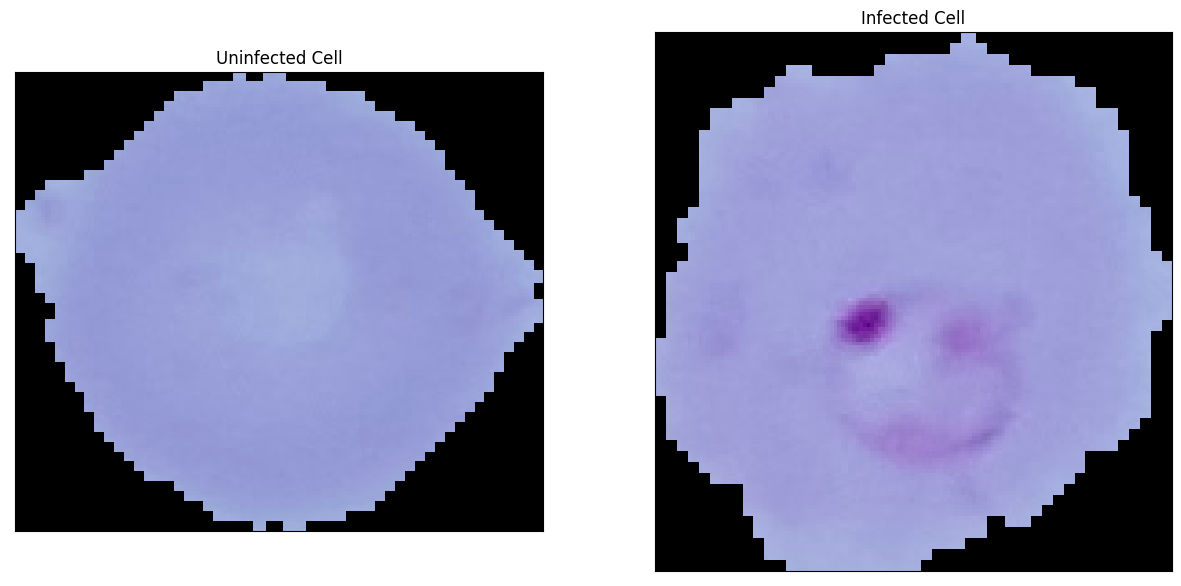

In [159]:
import cv2

# plot uninfected cell 
uinfected_path='../archive/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png'
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(cv2.imread(uinfected_path))
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

# plot infected cell 
inifected_path='../archive/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'
plt.subplot(1 , 2 , 2)
plt.imshow(cv2.imread(inifected_path))
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

### Split data into test and training sets

In [ ]:
image_width , image_height = 128, 128

# Use image data generator to rescale and splt data 
datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

train_datagen = datagen.flow_from_directory(directory='../archive/cell_images/cell_images/',
                                           target_size=(126,128),
                                           class_mode = 'binary',
                                           batch_size = 16,
                                           subset='training')

In [ ]:
test_datagen = datagen.flow_from_directory(directory='../archive/cell_images/cell_images/',
                                           target_size=(126,128),
                                           class_mode = 'binary',
                                seed = 0,
                                           batch_size = 16,
                                           subset='validation')

Found 5510 images belonging to 2 classes.


### Building the Model Structure

In [ ]:
# start with Sequential model 
model = Sequential()

# add first convolutional layer with a (128, 128) input sppacee
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(128,128,3)))

# add optimization layers MaxPool and Dropout
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

# 2nd concvolution
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

# 3rd concolution
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

# Flatten convolution layer 
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

# output layerr with sigmooid activation layer
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# show model summary 
model.summary()

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

### Train Model 

In [ ]:
from PIL import Image
early_stop = EarlyStopping(monitor='val_loss',patience=2)
epoch_count = 6
history = model.fit(x = train_datagen,
                             steps_per_epoch = len(train_datagen),
                              epochs = epoch_count,
                              validation_data = test_datagen,
                              validation_steps=len(test_datagen),
                              callbacks = [early_stop]
                            )
                          

## Learning and Traning Plots 

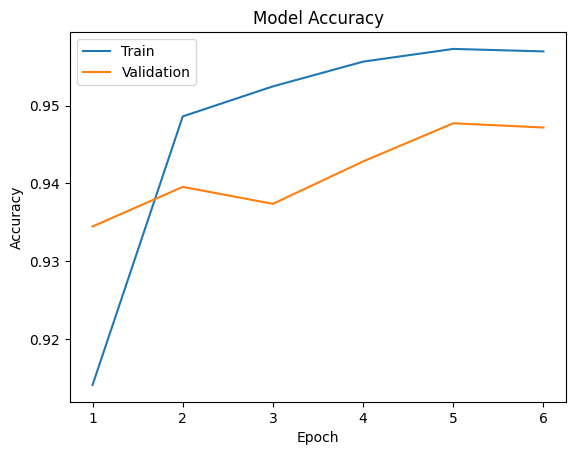

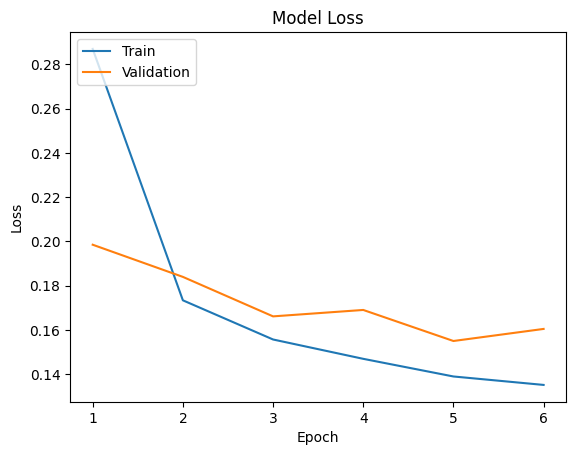

In [176]:
epochs = range(1,epoch_count + 1)
plt.plot(epochs,history.history['accuracy'])
plt.plot(epochs,history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')

plt.show()

plt.plot(epochs,history.history['loss'])
plt.plot(epochs,history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [177]:
history.history

{'loss': [0.28690165281295776,
  0.17342457175254822,
  0.15574011206626892,
  0.14701120555400848,
  0.1390446573495865,
  0.1352321058511734],
 'accuracy': [0.9141418933868408,
  0.9486120939254761,
  0.9524673223495483,
  0.9556422233581543,
  0.9572750329971313,
  0.9569575190544128],
 'val_loss': [0.1985192894935608,
  0.1839989572763443,
  0.16617535054683685,
  0.16907282173633575,
  0.15505827963352203,
  0.16050921380519867],
 'val_accuracy': [0.934482753276825,
  0.9395644068717957,
  0.9373865723609924,
  0.9428312182426453,
  0.9477313756942749,
  0.9471869468688965]}

### Evaluating Model

In [178]:
results = model.evaluate(test_datagen, batch_size=128)

345/345 [==============================] - 10s 30ms/step - loss: 0.1605 - accuracy: 0.9472


### Store model in a Pickle

In [ ]:
import pickle 
pickle.dump(model, open('model.pkl', 'wb'))

### Make predictions

In [290]:
test_labels = []
preds = []
test_images = []

for step in range(len(test_datagen)):
    data, label = test_datagen.__getitem__(step)
    data_img = [cv2.resize(img, (128, 128)) for img in data]  # resize the input data
    data = np.array(data_img)  # convert the resized data back to a NumPy array
    pred = model.predict(data)

    preds.extend(pred.tolist())
    test_labels.extend(label)
    test_images.extend(data_img)



1/1 [==============================] - 0s 27ms/step


In [291]:
len(test_images)

5510

In [292]:
# predictions= [np.round(pred[0]) for pred in preds]
predictions = [pred[0] for pred in preds]

predictions = [int(np.round(p)) for p in predictions]

test_labels = [int(l) for l in test_labels]

print("Length of labels:", len(test_labels))
print("Length of predictions:", len(predictions))


Length of labels: 5510
Length of predictions: 5510


array([[2561,  194],
       [  98, 2657]], dtype=int64)

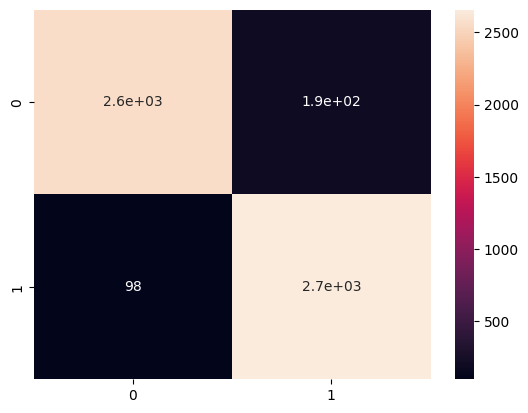

In [293]:
cf_matrix = confusion_matrix(test_labels, predictions)

sns.heatmap(cf_matrix, annot=True)
cf_matrix

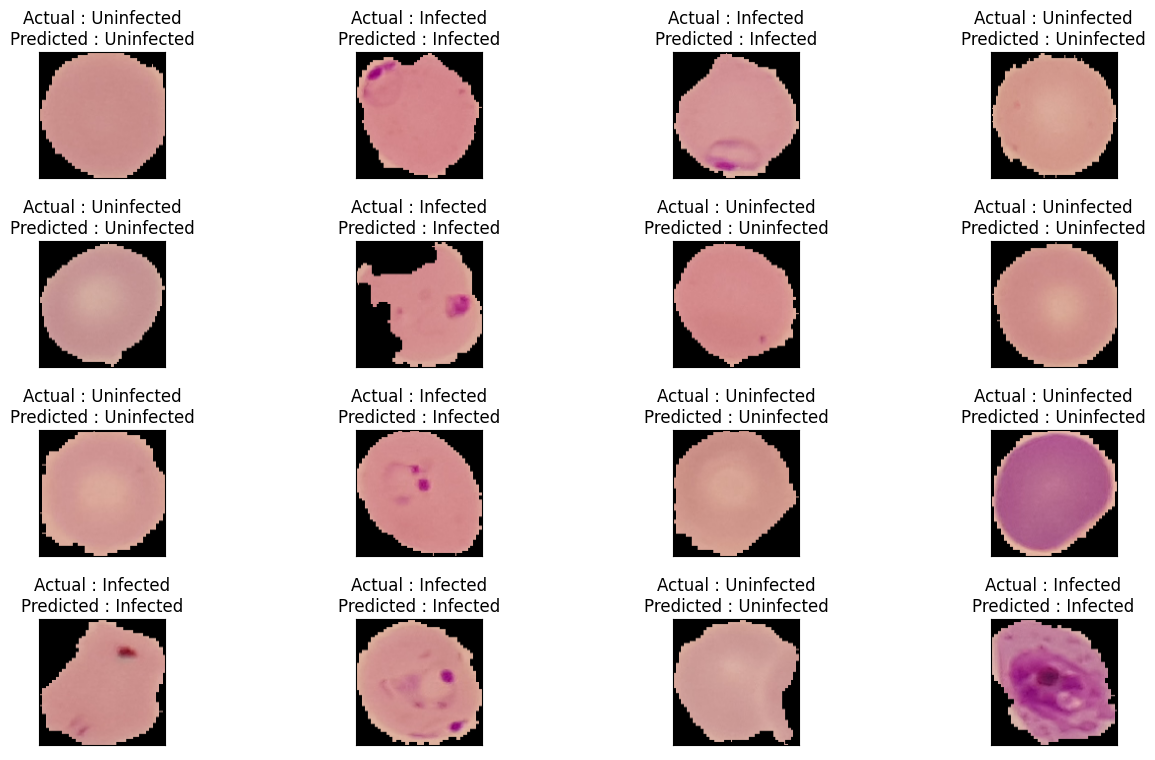

In [296]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
len(test_images)
for i in range(16):
    
    
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    r = np.random.randint(0 , len(predictions) , 1)[0]
    n += 1 
    plt.subplot(4 , 4, n)
    plt.imshow(test_images[r])
    # plt.title(f'{label[j]}'.   
    
    plt.title('Actual : {}\nPredicted : {}'.format('Uninfected' if test_labels[r] == 1 else 'Infected', 'Uninfected' if predictions[r] == 1 else 'Infected' ) )
    plt.xticks([]) , plt.yticks([])
    
plt.show()